In [1]:
#import socket
#socket.gethostname()
!hostname

n96.clstr


In [2]:
import geopandas as gpd
from shapely.geometry import box
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob
import regionmask
import xarray as xr
import numpy as np
import rioxarray
import imageio
from rasterio import features
from shapely.vectorized import contains

from shapely.geometry import Polygon, MultiPolygon

In [5]:
'''path='/center1/DYNDOWN/phutton5/ROS/netcdf_files/'
pattern=f'new*.nc'
file_list = sorted(glob.glob(os.path.join(path, pattern)))
datanew = xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')

path='/center1/DYNDOWN/phutton5/ROS/netcdf_files/climatology_ROS/'
pattern=f'ROS_T2_1940-1941.nc'
file_list = sorted(glob.glob(os.path.join(path, pattern)))
dataold = xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')
'''

"path='/center1/DYNDOWN/phutton5/ROS/netcdf_files/'\npattern=f'new*.nc'\nfile_list = sorted(glob.glob(os.path.join(path, pattern)))\ndatanew = xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')\n\npath='/center1/DYNDOWN/phutton5/ROS/netcdf_files/climatology_ROS/'\npattern=f'ROS_T2_1940-1941.nc'\nfile_list = sorted(glob.glob(os.path.join(path, pattern)))\ndataold = xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')\n"

Calling the borough data

In [4]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
#opened on qgis to see details on coordinate system
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
#print(borough_boundaries.head())
#print(borough_boundaries.columns)
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  

FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]
})
Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)

Calling the ERA5 data

In [5]:
path='/import/beegfs/CMIP6/wrf_era5/04km'
year='1940'
month='12'

folder = os.path.join(path, year)
pattern = f"era5_wrf_dscale_4km_{year}-{month}-*.nc"
#pattern = f"era5_wrf_dscale_4km_{year}*.nc"
file_list = sorted(glob.glob(os.path.join(folder, pattern)))
data = xr.open_mfdataset(file_list, combine='by_coords')
lat=data['XLAT']
lon=data['XLONG']
T2=data['T2']


Calling Landmask and elevation


In [6]:
os.chdir("/import/beegfs/CMIP6/wrf_era5")
path='/import/beegfs/CMIP6/wrf_era5'
geo_em_path = "/geo_em.d02.nc"
geo = xr.open_dataset(path+geo_em_path)
landmask = geo['LANDMASK']
landmask=landmask.squeeze(dim="Time")

print(list(geo.data_vars))

mask = regionmask.mask_geopandas(FNSB_boundary, lon, lat)

elevation=geo['HGT_M']
Elevation_masked = elevation.where(~np.isnan(mask))

T2_masked = T2.where(~np.isnan(mask))

['Times', 'XLAT_M', 'XLONG_M', 'XLAT_V', 'XLONG_V', 'XLAT_U', 'XLONG_U', 'CLAT', 'CLONG', 'MAPFAC_M', 'MAPFAC_V', 'MAPFAC_U', 'MAPFAC_MX', 'MAPFAC_VX', 'MAPFAC_UX', 'MAPFAC_MY', 'MAPFAC_VY', 'MAPFAC_UY', 'E', 'F', 'SINALPHA', 'COSALPHA', 'LANDMASK', 'XLAT_C', 'XLONG_C', 'SINALPHA_U', 'COSALPHA_U', 'SINALPHA_V', 'COSALPHA_V', 'LANDUSEF', 'LU_INDEX', 'HGT_M', 'SOILTEMP', 'SOILCTOP', 'SCT_DOM', 'SOILCBOT', 'SCB_DOM', 'ALBEDO12M', 'GREENFRAC', 'LAI12M', 'SNOALB', 'CON', 'VAR', 'OA1', 'OA2', 'OA3', 'OA4', 'OL1', 'OL2', 'OL3', 'OL4', 'VAR_SSO', 'LAKE_DEPTH']


In [ ]:
os.chdir("/import/beegfs/CMIP6/wrf_era5")
path='/import/beegfs/CMIP6/wrf_era5'
geo_em_path = "/geo_em.d02.nc"
geo = xr.open_dataset(path+geo_em_path)

mask = regionmask.mask_geopandas(FNSB_boundary, lon, lat)

elevation=geo['HGT_M']
Elevation_masked = elevation.where(~np.isnan(mask))


<xarray.Dataset> Size: 102MB
Dimensions:     (Time: 1, south_north: 450, west_east: 420,
                 south_north_stag: 451, west_east_stag: 421, land_cat: 21,
                 soil_cat: 16, month: 12)
Dimensions without coordinates: Time, south_north, west_east, south_north_stag,
                                west_east_stag, land_cat, soil_cat, month
Data variables: (12/53)
    Times       (Time) |S19 19B ...
    XLAT_M      (Time, south_north, west_east) float32 756kB ...
    XLONG_M     (Time, south_north, west_east) float32 756kB ...
    XLAT_V      (Time, south_north_stag, west_east) float32 758kB ...
    XLONG_V     (Time, south_north_stag, west_east) float32 758kB ...
    XLAT_U      (Time, south_north, west_east_stag) float32 758kB ...
    ...          ...
    OL1         (Time, south_north, west_east) float32 756kB ...
    OL2         (Time, south_north, west_east) float32 756kB ...
    OL3         (Time, south_north, west_east) float32 756kB ...
    OL4         (Time, south_north, west_east) float32 756kB ...
    VAR_SSO     (Time, south_north, west_east) float32 756kB ...
    LAKE_DEPTH  (Time, south_north, west_east) float32 756kB ...
Attributes: (12/48)
    TITLE:                           OUTPUT FROM GEOGRID V4.5
    SIMULATION_START_DATE:           0000-00-00_00:00:00
    WEST-EAST_GRID_DIMENSION:        421
    SOUTH-NORTH_GRID_DIMENSION:      451
    BOTTOM-TOP_GRID_DIMENSION:       0
    WEST-EAST_PATCH_START_UNSTAG:    1
    ...                              ...
    sr_x:                            1
    sr_y:                            1
    FLAG_MF_XY:                      1
    FLAG_LAI12M:                     1
    FLAG_VAR_SSO:                    1
    FLAG_LAKE_DEPTH:                 1

In [20]:
os.chdir("/import/beegfs/CMIP6/wrf_era5")
geo_em_path = "geo_em.d02.nc"
geo = xr.open_dataset(geo_em_path)
landmask = geo['LANDMASK']
landmask = landmask.squeeze(dim="Time")
landmask_expanded = landmask.expand_dims(Time=data.Time)

data_fixed = data.where(landmask_expanded == 1)
data_fixed = data_fixed.chunk(dict(south_north=-1, west_east=-1))
data_filled = data_fixed.interpolate_na(dim="south_north", method="nearest", fill_value="extrapolate")
data_filled = data_filled.interpolate_na(dim="west_east", method="nearest", fill_value="extrapolate")
data_final = data_filled.where(~np.isnan(landmask_expanded))
print("Land Mask Completed")

oceanmask=geo['LU_INDEX']
oceanmask=oceanmask.squeeze(dim='Time')
oceanmask_expanded = oceanmask.expand_dims(Time=data.Time)

#mask_all_AK=  regionmask.mask_geopandas(oceanmask_expanded, lon,lat)
data_masked = data_final.where(oceanmask_expanded != 17)

Land Mask Completed


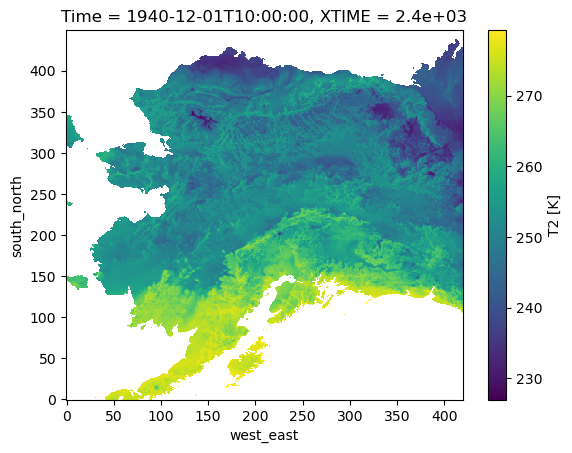

In [21]:
data_masked['T2'].isel(Time=10).plot()

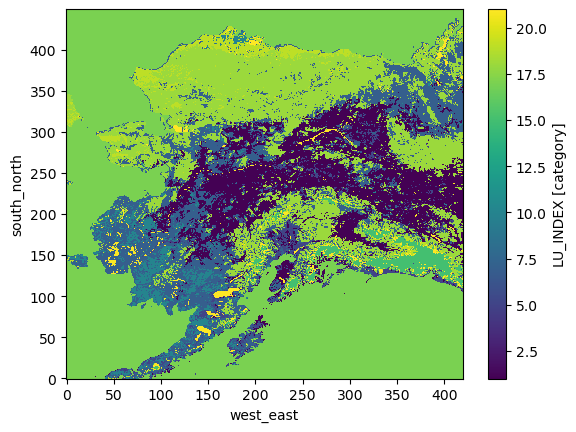

In [7]:
geo['LU_INDEX'].plot()

Adding rivers and cities to this map

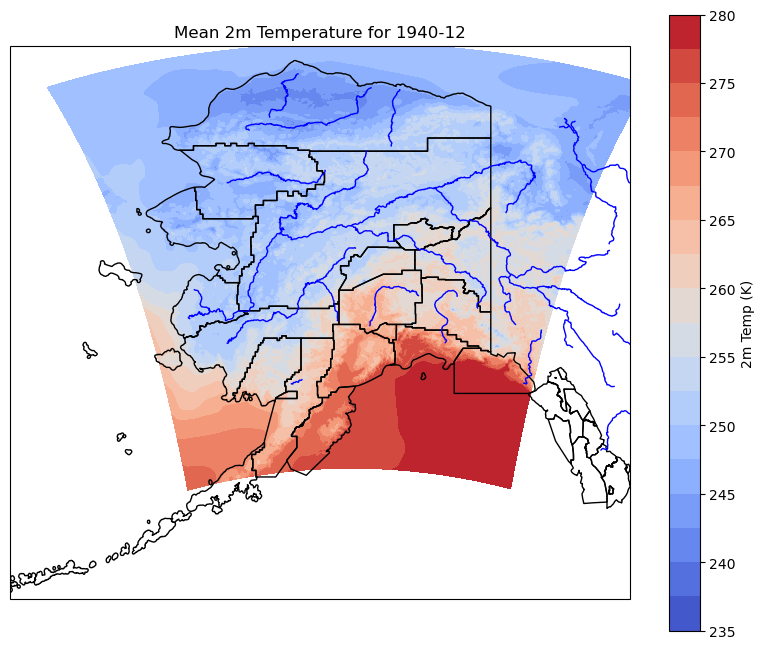

In [23]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(10, 8))
cf = ax.contourf(lon, lat, np.mean(T2, axis=0), levels=20, cmap='coolwarm', transform=ccrs.PlateCarree())

cbar = fig.colorbar(cf, ax=ax, label='2m Temp (K)')
borough_boundaries.to_crs(epsg=4326).plot(ax=ax, edgecolor="black", facecolor="none", linewidth=1, zorder=2, transform=ccrs.PlateCarree())
rivers = cfeature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='10m', facecolor='none', edgecolor='blue')
ax.add_feature(rivers, linewidth=1.0, zorder=3)
ax.set_title(f"Mean 2m Temperature for {year}-{month}")
ax.set_extent([-179, -130, 51, 72], crs=ccrs.PlateCarree())
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


THIS IS HOW I CAN FILTER ALL OF AK 
- 

In [6]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/ne_50m_land/ne_50m_land.shp"
land = gpd.read_file(shapefile_path).to_crs(epsg=4326)
alaska_bbox = box(-179, 50, -120, 72)
bbox_gdf = gpd.GeoDataFrame({"geometry": [alaska_bbox]}, crs="EPSG:4326")
alaska_land = gpd.clip(land, bbox_gdf)

mask_all_AK=regionmask.mask_geopandas(alaska_land, lon,lat)

mask_da = xr.DataArray(mask_all_AK, coords={"south_north": data.south_north, "west_east": data.west_east},
dims=["south_north", "west_east"])

data_masked = data.where(~np.isnan(mask_da))


In [1]:
data_masked['PSFC'].isel(Time=np.mean(Time)).plot()


NameError: name 'data_masked' is not defined

Working code for the boundary for boroughs

In [ ]:
mask = regionmask.mask_geopandas(FNSB_boundary, lon, lat)
#T2_masked = T2.where(mask == 0)

T2_masked = T2.where(~np.isnan(mask))
print("Non-NaN count:", T2_masked.notnull().sum().values)

Non-NaN count: 884616


In [19]:
mask = regionmask.mask_geopandas(FNSB_boundary, lon, lat)
data_masked = data.where(~np.isnan(mask))
FNSB_T2=data_masked['T2']
FNSB_SNOW=data_masked['SNOW']
FNSB_ACSNOW=data_masked['acsnow']
FNSB_RAINC=data_masked['rainc'] #convective 
FNSB_RAINNC=data_masked['rainnc']
FNSB_RAIN=FNSB_RAINNC-FNSB_ACSNOW

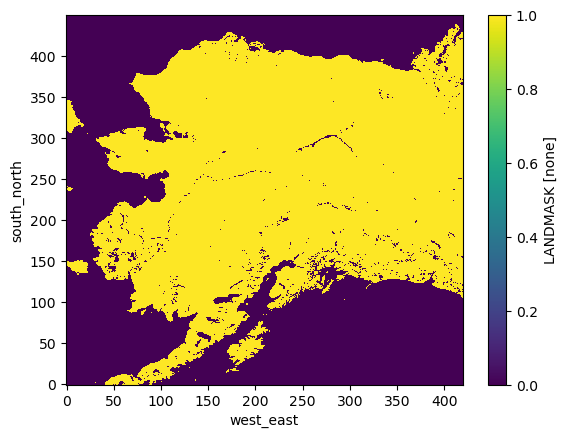

In [11]:
os.chdir("/import/beegfs/CMIP6/wrf_era5")
geo_em_path = "geo_em.d02.nc"
geo = xr.open_dataset(geo_em_path)
landmask = geo['LANDMASK']

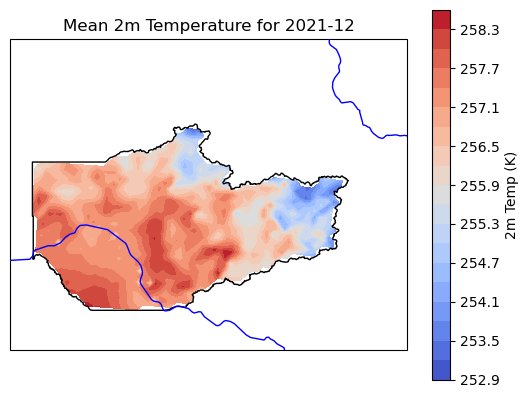

In [21]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})  
cf = ax.contourf(lon, lat, np.mean(FNSB_T2, axis=0), levels=20, cmap='coolwarm',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='2m Temp (K)')
FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2,transform=ccrs.PlateCarree())  
rivers = cfeature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale='10m', facecolor='none', edgecolor='blue',transform=ccrs.PlateCarree())
ax.add_feature(rivers, linewidth=1.0, zorder=3)
ax.set_title(f"Mean 2m Temperature for {year}-{month}")
ax.set_xlim(-149, -143)
ax.set_ylim(64, 66)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

How Peter defines ROS event:

" ROS events were identified if daily total rainfall was greater than or equal to 0.254 mm (equivalent to 0.01 in. of precipitation, which is the minimum measurement of the National Weather Service) and any of the following: 
1) there was snow on the ground but the daily maximum temperature was lower than 4°C,
2) the skin temperature was less than or equal to 0°C
3) the daily maximum air temperature was less than or equal to 0°C. 

This multiple criterion allowed for the identification of rain on frozen ground and rain on snow because both cause significant icing. Hereinafter, we will refer to all events as rain on snow or ROS for simplicity. The additional 4°C criterion was added as an upper bound for temperature only for the snow-on-the-ground cases to limit the inclusion of warm ROS in southern coastal areas since these events may not have any impactful ice accumulations because of high temperatures melting the ice/snow. 

There was intentional redundancy among the other subcriteria, and the 0°C skin temperature subcriterion (item 2 above) often captured ROS rain events occurring at air temperatures higher than 4°C 

Daily ROS events were then classified and ranked by the total rainfall amount. Days with an"y rain or mixed rain/snow (with liquid precipitation amounts of 0.254 mm or greater in both cases) were also identified for all grids and models to help evaluate the ROS results."

Defining Snow pack : Snow on the ground (1mm of SWE, which is 1kg/m2)

In [27]:
FNSB_ros_events=(FNSB_T2 >273) & (FNSB_RAIN > 2.54 ) & (FNSB_SNOW > 25.4) 
#Temberature  greater than 273 K 
#Total rainfall of at least 2.54 mm (0.1in)
#Snow depth exceeds 25.4 mm (1 in.) -- need to make sure this is at 
    #   both the start and end of the event.’ 
#Criteria from both Crawford et al 2020 and Bieniek et al 2018

FNSB_ros_tally = FNSB_ros_events.sum(dim='Time') 
#per hour, so max of 50 is how many hours that this occured during this period

In [38]:
import numpy as np
import rioxarray
import imageio
import glob
from rasterio import features
import os
from shapely.vectorized import contains
from shapely.geometry import Polygon, MultiPolygon
import time
from datetime import datetime
import argparse
from shapely.geometry import box

In [33]:
def load_Xyrs_winter_dataset(start_winter_year, X):
    print("Loading multi-year winter dataset...")
    load_start = time.time()
    months_first_year = ['12']
    months_second_year = ['01']
    all_file_list = []

    for i in range(X):
        year1 = start_winter_year + i
        year2 = year1 + 1
        path1 = f'/import/beegfs/CMIP6/wrf_era5/04km/{year1}'
        path2 = f'/import/beegfs/CMIP6/wrf_era5/04km/{year2}'

        for month in months_first_year:
            pattern = f"era5_wrf_dscale_4km_{year1}-{month}-*.nc"
            file_list = sorted(glob.glob(os.path.join(path1, pattern)))
            if file_list:
                all_file_list.extend(file_list)
            else:
                print(f"{year1}-{month}: ERROR No files found")

        for month in months_second_year:
            pattern = f"era5_wrf_dscale_4km_{year2}-{month}-*.nc"
            file_list = sorted(glob.glob(os.path.join(path2, pattern)))
            if file_list:
                all_file_list.extend(file_list)
            else:
                print(f"{year2}-{month}: ERROR No files found")
    load_end = time.time()
    print("Time to load X-year dataset (min):", round((load_end - load_start) / 60, 2))

    def select_vars(ds):
        return ds[['T2', 'SNOW', 'acsnow', 'rainnc', 'temp', 'XLAT', 'XLONG','Time']]

    if all_file_list:
        data = xr.open_mfdataset(all_file_list, combine='by_coords', preprocess=select_vars)
        print("X-year winter dataset opened and combined (selected variables only)!")
        return data
    else:
        raise ValueError("No files found across the X-year winter period!")

In [34]:
'''def land_mask(data, lat, lon):
    #mask = regionmask.mask_geopandas(shapefile, lon, lat)
    #data_masked = data.where(~np.isnan(mask))

    os.chdir("/import/beegfs/CMIP6/wrf_era5")
    geo_em_path = "geo_em.d02.nc"
    geo = xr.open_dataset(geo_em_path)
    landmask = geo['LANDMASK']
    landmask = landmask.squeeze(dim="Time")
    landmask_expanded = landmask.expand_dims(Time=data.Time)

    data_fixed = data.where(landmask_expanded == 1)
    data_fixed = data_fixed.chunk(dict(south_north=-1, west_east=-1))
    data_filled = data_fixed.interpolate_na(dim="south_north", method="nearest", fill_value="extrapolate")
    data_final = data_filled.interpolate_na(dim="west_east", method="nearest", fill_value="extrapolate")
    #data_final = data_filled.where(~np.isnan(mask))
    print("Land Mask Completed")
    return data_final'''

def land_mask(shapefile,data, lat, lon):
    os.chdir("/import/beegfs/CMIP6/wrf_era5")
    geo_em_path = "geo_em.d02.nc"
    geo = xr.open_dataset(geo_em_path)
    landmask = geo['LANDMASK']
    landmask = landmask.squeeze(dim="Time")
    landmask_expanded = landmask.expand_dims(Time=data.Time)

    data_fixed = data.where(landmask_expanded == 1)
    data_fixed = data_fixed.chunk(dict(south_north=-1, west_east=-1))
    data_filled = data_fixed.interpolate_na(dim="south_north", method="nearest", fill_value="extrapolate")
    data_filled = data_filled.interpolate_na(dim="west_east", method="nearest", fill_value="extrapolate")
    data_final = data_filled.where(~np.isnan(landmask_expanded))
    print("Land Mask and Alaska Mask Completed")

    land =shapefile.to_crs(epsg=4326)
    alaska_bbox = box(-179, 50, -120, 72)
    bbox_gdf = gpd.GeoDataFrame({"geometry": [alaska_bbox]}, crs="EPSG:4326")
    alaska_land = gpd.clip(land, bbox_gdf)
    mask_all_AK=  regionmask.mask_geopandas(alaska_land, lon,lat)

    mask_da = xr.DataArray(mask_all_AK, coords={"south_north": data.south_north, "west_east": data.west_east},dims=["south_north", "west_east"])
    data_masked = data_final.where(~np.isnan(mask_da))
    return data_masked



def get_winter_season_labels(time_index):
    labels = []
    for t in pd.to_datetime(time_index):
        if t.month in [11, 12]:
            labels.append(f"{t.year}-{t.year + 1}")
        elif t.month in [1, 2, 3]:
            labels.append(f"{t.year - 1}-{t.year}")
        else:
            labels.append(None)
    return np.array(labels)

In [35]:
def calculate_ros_events(data):
    T2 = data['T2']
    SNOW = data['SNOW']
    ACSNOW = data['acsnow']
    RAINNC = data['rainnc']
    RAIN = RAINNC - ACSNOW
    print('RAIN calc completed')

    ros_events = (RAIN > 0.254) & (SNOW > 2.54) #2.54 mm of swe? Solid Equivalent!!!
    print("ROS Events filtered")

    dates = ros_events['Time'].dt.date.data
    hours = ros_events['Time'].dt.hour.data
    ros_events = ros_events.assign_coords(Date=('Time', dates), Hour=('Time', hours))

    T2_avg = np.mean(T2, axis=0)
    print('T2_avg for Nov-Mar done')

    T2_during_ros = T2.where(ros_events)
    T2_ros_avg = T2_during_ros.mean(dim='Time')
    print('T2_ros_avg for ROS events done')

    if 'temp' in data:
        selected_t_levels = data['temp'].sel(interp_level=[850., 925., 950.])
        temp_levels_avg = selected_t_levels.mean(dim='Time')
        temp_levels_ros_avg = selected_t_levels.where(ros_events).mean(dim='Time')
        print('Pressure-level temp avgs done')
    else:
        temp_levels_avg = None
        temp_levels_ros_avg = None
        print('No pressure-level temperature data found')
    ros_tally = ros_events.sum(dim='Time')
    ros_events_filtered = ros_events.where(ros_events != 0).dropna(dim='Time', how='all')
    ros_counts = ros_events_filtered.count(dim='Time')
    ros_daily_counts = ros_events_filtered.groupby('Date').count(dim='Time')
    ros_days_count = ros_daily_counts.where(ros_daily_counts > 0).count(dim='Date')
    print("ROS Daily counted")
    return {
        'ros_events': ros_events,
        'ros_tally': ros_tally,
        'ros_counts': ros_counts,
        'ros_days_count': ros_days_count,
        'T2_avg': T2_avg,
        'T2_ros_avg': T2_ros_avg,
        'temp_levels_avg': temp_levels_avg,
        'temp_levels_ros_avg': temp_levels_ros_avg}


In [36]:
def calculate_vars_by_winter_season(full_data):
    time_values = full_data['Time'].values
    season_labels = get_winter_season_labels(time_values)
    unique_seasons = sorted(set(season_labels) - {None})
    print("Starting to gather temp, snow, rain... by winter season...")
    ros_start = time.time()

    ros_tally_list = []
    ros_counts_list = []
    ros_days_count_list = []
    ros_time_series_list = []

    for season in unique_seasons:
        time_mask = season_labels == season
        selected_times = time_values[time_mask]
        seasonal_data = full_data.sel(Time=selected_times)

        ros_result = calculate_ros_events(seasonal_data)

        ros_tally_list.append(ros_result['ros_tally'].expand_dims(season=[season]))
        ros_counts_list.append(ros_result['ros_counts'].expand_dims(season=[season]))
        ros_days_count_list.append(ros_result['ros_days_count'].expand_dims(season=[season]))

        ros_ds_vars = {
            'T2_avg': ros_result['T2_avg'],
            'T2_ros_avg': ros_result['T2_ros_avg']
        }

        if ros_result['temp_levels_avg'] is not None:
            ros_ds_vars['temp_levels_avg'] = ros_result['temp_levels_avg']
            ros_ds_vars['temp_levels_ros_avg'] = ros_result['temp_levels_ros_avg']

        ros_ds = xr.Dataset(ros_ds_vars).expand_dims(season=[season])
        ros_time_series_list.append(ros_ds)

    summary_ds = xr.Dataset({
        'ros_tally': xr.concat(ros_tally_list, dim='season'),
        'ros_counts': xr.concat(ros_counts_list, dim='season'),
        'ros_days_count': xr.concat(ros_days_count_list, dim='season')
    })
    time_series_ds = xr.concat(ros_time_series_list, dim='season')
    combined_ds = xr.merge([summary_ds, time_series_ds])
    ros_end = time.time()

    print('Completed ROS by winter season.')
    print("Total time for seasonal ROS calc (min):", round((ros_end - ros_start) / 60, 2))
    return combined_ds

In [ ]:
winter_start=1940
ds = load_Xyrs_winter_dataset(winter_start, 1)
lat = ds['XLAT']
lon = ds['XLONG']

shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/ne_50m_land/ne_50m_land.shp"
boundaries = gpd.read_file(shapefile_path)

ds_borough = land_mask(boundaries,ds, lat, lon)
    #step 3 is to run the calculations that tall hours and days of ROS
seasonal_ros = calculate_vars_by_winter_season(ds_borough)
    #step 4 is to output into a netcdf file

#output_path = f"/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/ROS_Tlevels_{winter_start}-{winter_start+1}.nc"
#seasonal_ros.to_netcdf(output_path)

#print(f"Saved NetCDF: {output_path}")
#except Exception as e:
#print(f"Error processing winter {winter_start}-{winter_start + 1}: {e}")


Loading multi-year winter dataset...
Time to load X-year dataset (min): 0.0
X-year winter dataset opened and combined (selected variables only)!
Land Mask and Alaska Mask Completed
Starting to gather temp, snow, rain... by winter season...
RAIN calc completed
ROS Events filtered
T2_avg for Nov-Mar done
T2_ros_avg for ROS events done
Pressure-level temp avgs done
ROS Daily counted
Completed ROS by winter season.
Total time for seasonal ROS calc (min): 8.93


: 

Exploring the DEM 
- 


In [46]:
#ARDEMv2.0.nc
outline = xr.open_dataset("/center1/DYNDOWN/phutton5/ROS/boundaries/ARDEMv2.0.nc")
DEM_elevation=outline['z']
DEM_lon=outline['lon']
DEM_lat=outline['lat']

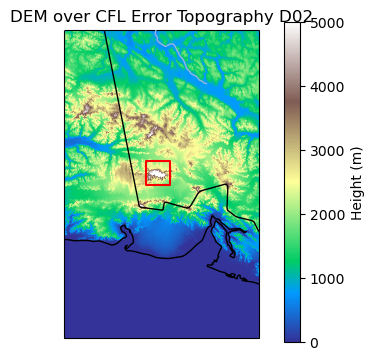

In [31]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 11, 1)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
#cf = ax.pcolormesh(lon, lat,HGT_M,cmap='terrain',transform=ccrs.PlateCarree())
cf = ax.pcolormesh(outline['lon'], outline['lat'], outline['z'],cmap='terrain',vmin=0, vmax=5000, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Height (m)')
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
ax.scatter(-140.458054,60.607914, marker='s', s=300, edgecolors='red', facecolors='none', linewidths=1.5,transform=ccrs.PlateCarree(), zorder=10 )
#ax.scatter(lon,lat, marker='*', color='k', zorder=5, s=75, label='Fairbanks', transform=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)
ax.set_title("DEM over CFL Error Topography D02")
ax.set_extent([-142, -139, 59, 62], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

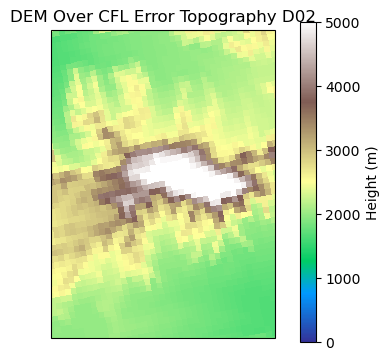

In [32]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 11, 1)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4))
cf = ax.pcolormesh(outline['lon'], outline['lat'], outline['z'],cmap='terrain',vmin=0, vmax=5000, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Height (m)')
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])
#ax.scatter(-140.458054,60.607914, marker='o', s=500, edgecolors='red', facecolors='none', linewidths=1.5,transform=ccrs.PlateCarree(), zorder=10 )

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)
ax.set_title("DEM Over CFL Error Topography D02")
ax.set_extent([-140.8, -140.3, 60.4, 60.8], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

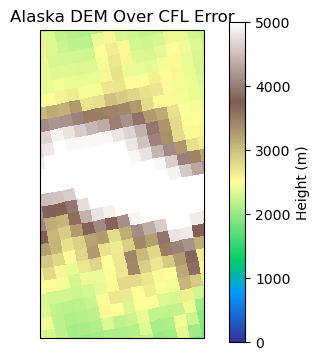

In [26]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 5000, 1000)
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4)) 

cf = ax.pcolormesh(outline['lon'], outline['lat'], outline['z'],cmap='terrain',vmin=0, vmax=5000, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Height (m)') 
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8]) 
#ax.scatter(-140.458054,60.607914, marker='s', s=1500, edgecolors='red', facecolors='none', linewidths=1.5,transform=ccrs.PlateCarree(), zorder=10 ) 
ax.add_feature(cfeature.BORDERS, zorder=9) 
ax.add_feature(cfeature.COASTLINE, zorder=9) 
ax.add_feature(cfeature.RIVERS, zorder=9) 
ax.set_title("Alaska DEM Over CFL Error") 
ax.set_extent([-140.55, -140.4, 60.5, 60.7], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude") 
ax.set_ylabel("Latitude") 
plt.show()

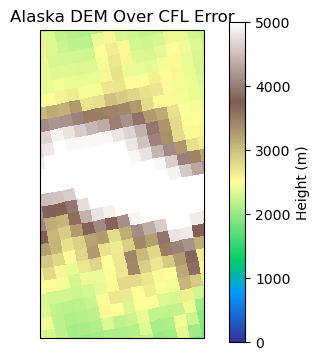

In [41]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 5000, 1000)
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4)) 
cf = ax.pcolormesh(outline['lon'], outline['lat'], DEM_elevation,cmap='terrain',vmin=0, vmax=5000, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Height (m)') 
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8]) 
#ax.scatter(-140.458054,60.607914, marker='s', s=1500, edgecolors='red', facecolors='none', linewidths=1.5,transform=ccrs.PlateCarree(), zorder=10 ) 
ax.add_feature(cfeature.BORDERS, zorder=9) 
ax.add_feature(cfeature.COASTLINE, zorder=9) 
ax.add_feature(cfeature.RIVERS, zorder=9) 
ax.set_title("Alaska DEM Over CFL Error") 
ax.set_extent([-140.55, -140.4, 60.5, 60.7], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude") 
ax.set_ylabel("Latitude") 
plt.show()

In [53]:
lon_flat = DEM_lon.values.ravel()
lat_flat = DEM_lat.values.ravel()
DEM_flat = DEM_elevation.values.ravel()

lon2d, lat2d = np.meshgrid(DEM_lon, DEM_lat) 
lon_flat = lon2d.ravel()
lat_flat = lat2d.ravel()
DEM_flat = DEM_elevation.values.ravel()



lon_min, lon_max = -141.0, -140
lat_min, lat_max = 60, 61
#-140.55, -140.4, 60.5, 60.7
mask = (
    (lon_flat >= lon_min) & (lon_flat <= lon_max) &
    (lat_flat >= lat_min) & (lat_flat <= lat_max)
)
DEM_filtered = DEM_flat[mask]
'''

mask_2d = ((lon >= lon_min) & (lon <= lon_max) & (lat >= lat_min) & (lat <= lat_max) )

DEM_elevation_masked = np.ma.masked_where(~mask_2d, DEM_elevation)
DEM_elevation_plot = np.where(mask_2d, DEM_elevation, np.nan)
'''

'\n\nmask_2d = ((lon >= lon_min) & (lon <= lon_max) & (lat >= lat_min) & (lat <= lat_max) )\n\nDEM_elevation_masked = np.ma.masked_where(~mask_2d, DEM_elevation)\nDEM_elevation_plot = np.where(mask_2d, DEM_elevation, np.nan)\n'

ValueError: not enough values to unpack (expected 2, got 1)

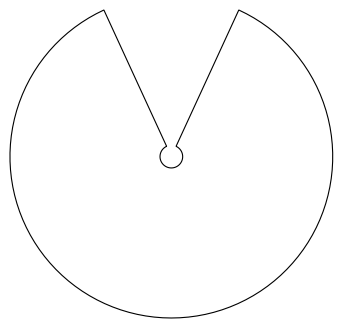

In [55]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
levels = np.arange(0, 5000, 1000)
fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 4)) 
cf = ax.pcolormesh(DEM_lon, DEM_lat, DEM_filtered, cmap='terrain',vmin=0, vmax=5000, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Height (m)') 
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8]) 
#ax.scatter(-140.458054,60.607914, marker='s', s=1500, edgecolors='red', facecolors='none', linewidths=1.5,transform=ccrs.PlateCarree(), zorder=10 ) 
for i in range(DEM_filtered.shape[0]):
    for j in range(DEM_filtered.shape[1]):
        if DEM_filtered[i, j] > 2000:
            lon_val = lon[i, j]
            lat_val = lat[i, j]
            if (lon_min <= lon_val <= lon_max) and (lat_min <= lat_val <= lat_max):
                ax.text(
                    lon_val, lat_val, f"{HGT_masked[i, j]:.0f}",
                    transform=ccrs.PlateCarree(),
                    fontsize=8, color='black', ha='center', va='center', zorder=11)
ax.add_feature(cfeature.BORDERS, zorder=9) 
ax.add_feature(cfeature.COASTLINE, zorder=9) 
ax.add_feature(cfeature.RIVERS, zorder=9) 
ax.set_title("Alaska DEM Over CFL Error") 
ax.set_extent([-140.55, -140.4, 60.5, 60.7], crs=ccrs.PlateCarree()) 
ax.set_aspect('equal') 
ax.set_xlabel("Longitude") 
ax.set_ylabel("Latitude") 
plt.show()